# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [106]:
!pip install bigartm
import artm

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [108]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [109]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='lectures_batches', batch_size=250)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [110]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [111]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [112]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name='top_words1', class_id='text', num_tokens=15))
model_artm.scores.add(artm.TopTokensScore(name='top_words2', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [113]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [114]:
# Ваш код
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [115]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [116]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [117]:
# Ваш код
for topic_name in model_artm.topic_names:
    print (topic_name + ': '),
    tokens = model_artm.score_tracker["top_words1"].last_tokens
    for word in tokens[topic_name]:    
        print (word,end=', '),
    print()

sbj0: 
церковь, власть, средневековый, император, русь, святой, римский, папа, князь, сага, король, александр, византийский, вера, рим, 
sbj1: 
планета, земля, атмосфера, солнце, солнечный, белый, газ, образовываться, карлик, вокруг, вода, поверхность, спутник, орбита, океан, 
sbj2: 
система, трудность, поведение, частота, двигаться, точность, искусственный, движение, относительность, тест, час, самка, задание, переход, часы, 
sbj3: 
культура, понятие, культурный, восприятие, сознание, феномен, личность, воспринимать, ощущение, чувство, повседневный, переживание, детство, этика, индивид, 
sbj4: 
право, литература, искусство, литературный, юрист, писатель, должник, собственность, обязательство, владение, римский, произведение, исполнение, юридический, требование, 
sbj5: 
материал, структура, молекула, свойство, углерод, применение, поверхность, полимер, кристалл, металл, электронный, твердый, трехмерный, алмаз, углеродный, 
sbj6: 
книга, фильм, автор, кино, написать, документ, жанр, теа

In [118]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': '),
    tokens = model_artm.score_tracker["top_words2"].last_tokens
    for word in tokens[topic_name]:    
        print (word,end=', '),
    print()

sbj0: 
Александр_Марей, Фёдор_Успенский, Татьяна_Бобровникова, Павел_Уваров, Алексей_Юдин, Игорь_Данилевский, Ольга_Вайнштейн, Елена_Уханова, Ольга_Брилева, Владимир_Петрухин, Елена_Браун, Григорий_Бондаренко, Раиса_Кирсанова, Екатерина_Болтунова, Ольга_Тогоева, 
sbj1: 
Сергей_Попов, Кирилл_Еськов, Дмитрий_Вибе, Дмитрий_Титов, Валерий_Сулейманов, Зоригто_Намсараев, Сергей_Наугольных, Александр_Марков, Елизавета_Ривкина, Наталья_Новикова, Александр_Слободкин, Роман_Рафиков, Сергей_Писарев, Дмитрий_Лось, Юлия_Краус, 
sbj2: 
Елена_Брызгалина, Александр_Поддьяков, Михаил_Пантелеев, Владимир_Мележик, Эмиль_Ахмедов, Антон_Суворов, Даниэль_Сельва, Михаил_Фейгельман, Виталий_Пальчиков, Василий_Климов, Алексей_Желтиков, Юджин_Ползик, Илья_Щуров, Владимир_Редько, Алексей_Котов, 
sbj3: 
Пётр_Турчин, Сергей_Арутюнов, Алексей_Руткевич, Владимир_Миронов, Татьяна_Смоктунович, Андрей_Лосев, Константин_Анохин, Кирилл_Разлогов, Павел_Умрюхин, Фёдор_Гиренок, Дмитрий_Иванов, Павел_Степанцов, Александр_Кис

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [119]:
sbj_topic_labels = []   # запишите названия тем в список

tokens = model_artm.score_tracker['top_words1'].last_tokens

for topic_name in model_artm.topic_names[:29]:
    sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + ["Фоновая тема"]
topic_labels

['церковь',
 'планета',
 'система',
 'культура',
 'право',
 'материал',
 'книга',
 'смерть',
 'метод',
 'частица',
 'война',
 'ребенок',
 'растение',
 'территория',
 'звезда',
 'задача',
 'раса',
 'политический',
 'слово',
 'революция',
 'город',
 'болезнь',
 'социальный',
 'матрица',
 'исторический',
 'язык',
 'страна',
 'клетка',
 'температура',
 'Фоновая тема']

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [120]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
print('Theta shape: ' , theta.shape)
phi_a = model_artm.get_phi(class_ids='author')
print('Phi_a shape: ',  phi_a.shape)

Theta shape:  (30, 1728)
Phi_a shape:  (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

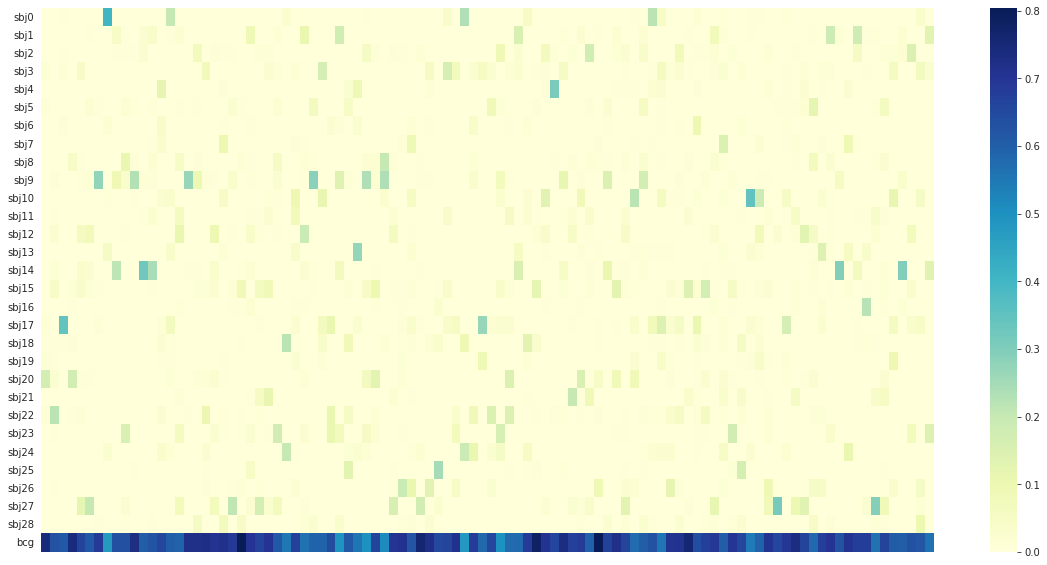

,http://postnauka.ru/video/32900,http://postnauka.ru/video/32901,http://postnauka.ru/video/32906,http://postnauka.ru/video/32918,http://postnauka.ru/video/32921,http://postnauka.ru/video/32924,http://postnauka.ru/video/33189,http://postnauka.ru/video/3348,http://postnauka.ru/video/3349,http://postnauka.ru/video/3352,http://postnauka.ru/video/3355,http://postnauka.ru/video/33755,http://postnauka.ru/video/33756,http://postnauka.ru/video/33758,http://postnauka.ru/video/33761,http://postnauka.ru/video/33763,http://postnauka.ru/video/33765,http://postnauka.ru/video/33767,http://postnauka.ru/video/33769,http://postnauka.ru/video/33771,http://postnauka.ru/video/33774,http://postnauka.ru/video/33777,http://postnauka.ru/video/33779,http://postnauka.ru/video/33782,http://postnauka.ru/video/33784,http://postnauka.ru/video/33786,http://postnauka.ru/video/33788,http://postnauka.ru/video/3379,http://postnauka.ru/video/33791,http://postnauka.ru/video/33793,http://postnauka.ru/video/33795,http://postnauka.ru/video/33797,http://postnauka.ru/video/3380,http://postnauka.ru/video/3381,http://postnauka.ru/video/3386,http://postnauka.ru/video/3387,http://postnauka.ru/video/3388,http://postnauka.ru/video/33885,http://postnauka.ru/video/3389,http://postnauka.ru/video/3390,...,http://postnauka.ru/video/34424,http://postnauka.ru/video/34426,http://postnauka.ru/video/34427,http://postnauka.ru/video/34430,http://postnauka.ru/video/34789,http://postnauka.ru/video/34925,http://postnauka.ru/video/34936,http://postnauka.ru/video/34938,http://postnauka.ru/video/34941,http://postnauka.ru/video/34946,http://postnauka.ru/video/34948,http://postnauka.ru/video/34950,http://postnauka.ru/video/34953,http://postnauka.ru/video/34955,http://postnauka.ru/video/34960,http://postnauka.ru/video/34962,http://postnauka.ru/video/34963,http://postnauka.ru/video/34964,http://postnauka.ru/video/35038,http://postnauka.ru/video/35041,http://postnauka.ru/video/35045,http://postnauka.ru/video/35048,http://postnauka.ru/video/35051,http://postnauka.ru/video/35053,http://postnauka.ru/video/35055,http://postnauka.ru/video/35058,http://postnauka.ru/video/35065,http://postnauka.ru/video/35067,http://postnauka.ru/video/35070,http://postnauka.ru/video/35072,http://postnauka.ru/video/3509,http://postnauka.ru/video/3511,http://postnauka.ru/video/35150,http://postnauka.ru/video/35461,http://postnauka.ru/video/35464,http://postnauka.ru/video/3599,http://postnauka.ru/video/3601,http://postnauka.ru/video/3602,http://postnauka.ru/video/3603,http://postnauka.ru/video/3604
sbj0,0.000000e+00,0.000000e+00,4.821551e-03,1.984654e-08,0.000000e+00,0.000000e+00,1.373995e-08,4.049006e-01,0.000000e+00,0.000000e+00,2.053475e-04,0.000000e+00,0.000000e+00,9.261240e-06,2.037733e-01,6.722505e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.468075e-06,2.199248e-06,0.000000e+00,7.875994e-13,0.000000e+00,1.529829e-10,0.000000e+00,2.901103e-02,1.700293e-12,0.000000e+00,0.000000e+00,3.424382e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000006,7.145148e-03,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.091936e-15,2.622297e-15,3.689195e-03,0.000000e+00,2.166843e-01,4.696759e-02,0.000000e+00,3.615393e-05,0.000000e+00,1.283851e-02,5.515895e-14,0.000000e+00,8.704319e-03,0.000000e+00,1.326406e-08,4.607912e-03,8.174727e-03,0.000000e+00,0.000000,6.954589e-03,1.213371e-16,0.000000e+00,0.000000e+00,1.145075e-09,0.000000e+00,3.268327e-13,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.448192e-02,0.000000
sbj1,0.000000e+00,1.661020e-13,0.000000e+00,0.000000e+00,0.000000e+00,6.580670e-03,2.957082e-11,0.000000e+00,4.895825e-02,4.760724e-03,1.607464e-03,2.267647e-02,4.188010e-02,0.000000e+00,4.103293e-03,2.024445e-02,5.866839e-08,7.270557e-15,0.000000e+00,0.000000e+00,0.000000e+00,5.016392e-06,0.000000e+00,8.848619e-02,1.400940e-11,9.061673e-06,1.372388e-02,0.000000e+00,4.542591e-05,1.074487e-01,5.786957e-04,0.000000e+00,0.00

In [121]:
# Ваш код
plt.figure(figsize=(20,10))
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show()
theta.iloc[:,:100]


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [122]:
# Ваш код
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme = pd.DataFrame(prob_theme_data / np.sum(prob_theme_data), index=topic_labels, columns=['prob'])
prob_theme

,prob
церковь,0.011971
планета,0.012342
система,0.009094
культура,0.014260
право,0.008992
материал,0.010729
книга,0.007117
смерть,0.004974
метод,0.014311
частица,0.022604


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [123]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]

Max 5 probabilities:
Фоновая тема
клетка
частица
звезда
политический

Min 3 probabilities:
раса
смерть
температура


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

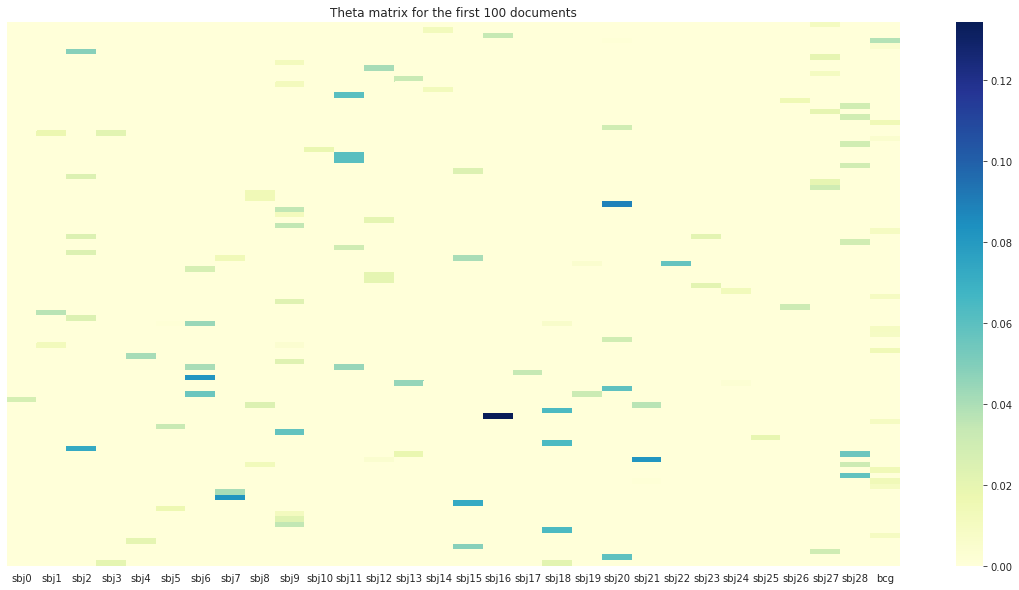

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,sbj13,sbj14,sbj15,sbj16,sbj17,sbj18,sbj19,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Надежда_Антипова,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,3.183038e-14,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.010112,0.000000e+00,0.000000
Лайман_Пейдж,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.012324,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,3.446596e-10,0.000000
Митчел_Резник,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.033599,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000
ПостНаука,0.0,0.000000,0.0,0.0,2.324973e-14,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,1.270656e-12,0.000000,0.0,0.001458,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.037898
Харольд_Крото,0.0,0.000000,0.0,0.0,0.000000e+00,9.300331e-14,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,1.108762e-10,0.004766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Евгений_Гудилин,0.0,0.000000,0.0,0.0,0.000000e+00,4.920012e-02,0.0,0.000000,2.526003e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000
Владимир_Муронец,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,1.146100e-03,0.0,0.000000,0.0,0.012778,0.000000e+00,0.000000,0.0,0.000000,2.370047e-08,0.0,0.0,0.0,0.0,0.0,0.025930,0.000000e+00,0.000000
Елизавета_Ривкина,0.0,0.036795,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000
Алексей_Лебедев,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.088961,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000


In [124]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show()
phi_a.iloc[:,:100]


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [142]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i, end=' ')
        print(phi_a.index[i])
#print(phi_a.iloc[184])

292 Елена_Брызгалина
359 Андрей_Цатурян
416 Дмитрий_Лось
538 Алина_Бодрова


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [126]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [127]:
# Ваш код
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

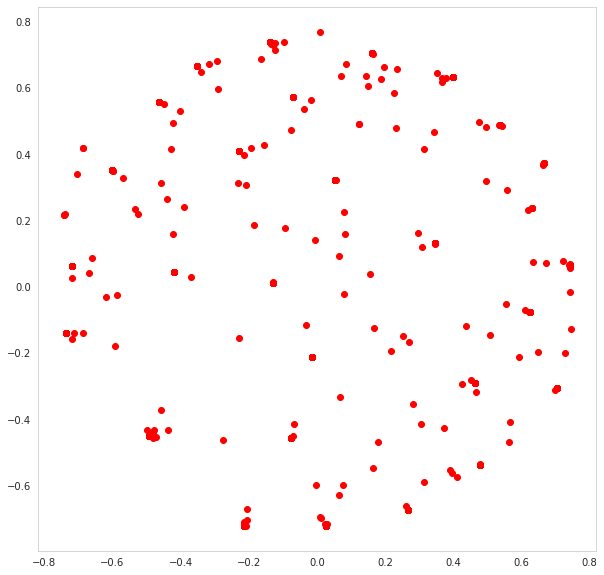

In [128]:
# Ваш код
plt.figure(figsize=(10,10))
plt.scatter(pos[:,0], pos[:,1], color = 'red')
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

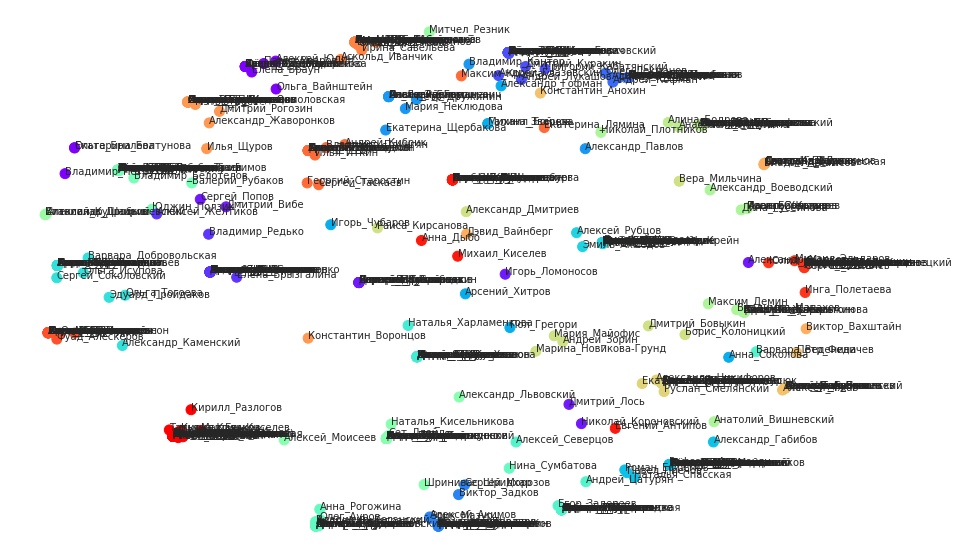

In [129]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]

plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])

for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')

plt.show()

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [140]:
# Ваш код #######
prob = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_sort = prob.argsort(axis=1)[:,::-1]
print(prob_sort)
theta

[[ 692    7  436 ...  942  940    0]
 [1397 1725 1699 ...  678  677    0]
 [ 253 1299 1358 ...  707  706    0]
 ...
 [ 576  987  303 ... 1265  607    0]
 [1626 1272 1670 ...  726  725    0]
 [1056 1317 1256 ... 1397  718  653]]


,http://postnauka.ru/video/32900,http://postnauka.ru/video/32901,http://postnauka.ru/video/32906,http://postnauka.ru/video/32918,http://postnauka.ru/video/32921,http://postnauka.ru/video/32924,http://postnauka.ru/video/33189,http://postnauka.ru/video/3348,http://postnauka.ru/video/3349,http://postnauka.ru/video/3352,http://postnauka.ru/video/3355,http://postnauka.ru/video/33755,http://postnauka.ru/video/33756,http://postnauka.ru/video/33758,http://postnauka.ru/video/33761,http://postnauka.ru/video/33763,http://postnauka.ru/video/33765,http://postnauka.ru/video/33767,http://postnauka.ru/video/33769,http://postnauka.ru/video/33771,http://postnauka.ru/video/33774,http://postnauka.ru/video/33777,http://postnauka.ru/video/33779,http://postnauka.ru/video/33782,http://postnauka.ru/video/33784,http://postnauka.ru/video/33786,http://postnauka.ru/video/33788,http://postnauka.ru/video/3379,http://postnauka.ru/video/33791,http://postnauka.ru/video/33793,http://postnauka.ru/video/33795,http://postnauka.ru/video/33797,http://postnauka.ru/video/3380,http://postnauka.ru/video/3381,http://postnauka.ru/video/3386,http://postnauka.ru/video/3387,http://postnauka.ru/video/3388,http://postnauka.ru/video/33885,http://postnauka.ru/video/3389,http://postnauka.ru/video/3390,...,http://postnauka.ru/video/31664,http://postnauka.ru/video/31666,http://postnauka.ru/video/31671,http://postnauka.ru/video/31675,http://postnauka.ru/video/31677,http://postnauka.ru/video/31679,http://postnauka.ru/video/31682,http://postnauka.ru/video/31684,http://postnauka.ru/video/31686,http://postnauka.ru/video/31688,http://postnauka.ru/video/31690,http://postnauka.ru/video/31695,http://postnauka.ru/video/31703,http://postnauka.ru/video/31705,http://postnauka.ru/video/31707,http://postnauka.ru/video/31712,http://postnauka.ru/video/31990,http://postnauka.ru/video/32150,http://postnauka.ru/video/32307,http://postnauka.ru/video/32341,http://postnauka.ru/video/32608,http://postnauka.ru/video/32627,http://postnauka.ru/video/32632,http://postnauka.ru/video/32635,http://postnauka.ru/video/32637,http://postnauka.ru/video/32639,http://postnauka.ru/video/32641,http://postnauka.ru/video/32660,http://postnauka.ru/video/32662,http://postnauka.ru/video/32664,http://postnauka.ru/video/32668,http://postnauka.ru/video/32669,http://postnauka.ru/video/32670,http://postnauka.ru/video/32671,http://postnauka.ru/video/32881,http://postnauka.ru/video/32882,http://postnauka.ru/video/32886,http://postnauka.ru/video/32889,http://postnauka.ru/video/32896,http://postnauka.ru/video/32898
sbj0,0.000000e+00,0.000000e+00,4.821551e-03,1.984654e-08,0.000000e+00,0.000000e+00,1.373995e-08,4.049006e-01,0.000000e+00,0.000000e+00,2.053475e-04,0.000000e+00,0.000000e+00,9.261240e-06,2.037733e-01,6.722505e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.468075e-06,2.199248e-06,0.000000e+00,7.875994e-13,0.000000e+00,1.529829e-10,0.000000e+00,2.901103e-02,1.700293e-12,0.000000e+00,0.000000e+00,3.424382e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000006,7.145148e-03,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.280484e-03,1.459333e-14,0.000000e+00,2.767103e-01,0.000000e+00,7.914328e-05,0.000000e+00,2.205885e-04,6.753095e-07,5.892671e-04,0.000000e+00,1.851017e-16,0.000000e+00,5.833264e-09,1.092181e-01,5.670988e-02,1.906514e-12,1.040596e-13,0.000000e+00,0.000000e+00,0.000000e+00,1.189893e-11,0.000000e+00,1.905388e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.867842e-02,0.000000e+00,1.621137e-03,1.648085e-05,8.199506e-03,0.000000e+00,7.533732e-02,0.000000e+00,7.517394e-11,0.000000e+00,0.000000e+00
sbj1,0.000000e+00,1.661020e-13,0.000000e+00,0.000000e+00,0.000000e+00,6.580670e-03,2.957082e-11,0.000000e+00,4.895825e-02,4.760724e-03,1.607464e-03,2.267647e-02,4.188010e-02,0.000000e+00,4.103293e-03,2.024445e-02,5.866839e-08,7.270557e-15,0.000000e+00,0.000000e+00,0.000000e+00,5.016392e-06,0.000000e+00,8.848619e-02,1.400940e-11,9.061673e-06,1.372388e-02,0.000000e+00,4.542591e-05,1.074487e-01,5.78695

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [131]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [135]:
from IPython.core.display import display, HTML
display(HTML(u"<h3>Заголовок</h3>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [139]:
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h2>%s</h2>" % theme))
    for k in range(10):
        print(tokens[model_artm.topic_names[i]][k] ,': ',theta.columns[prob_sort[i,k]])

церковь :  http://postnauka.ru/video/31196
власть :  http://postnauka.ru/video/2522
средневековый :  http://postnauka.ru/video/54343
император :  http://postnauka.ru/video/24473
русь :  http://postnauka.ru/video/54335
святой :  http://postnauka.ru/video/54372
римский :  http://postnauka.ru/video/57316
папа :  http://postnauka.ru/video/26612
князь :  http://postnauka.ru/video/1870
сага :  http://postnauka.ru/video/24182


планета :  http://postnauka.ru/video/40278
земля :  http://postnauka.ru/video/44728
атмосфера :  http://postnauka.ru/video/38501
солнце :  http://postnauka.ru/video/48677
солнечный :  http://postnauka.ru/video/8662
белый :  http://postnauka.ru/video/57443
газ :  http://postnauka.ru/video/25318
образовываться :  http://postnauka.ru/video/35038
карлик :  http://postnauka.ru/video/20293
вокруг :  http://postnauka.ru/video/22977


система :  http://postnauka.ru/video/50792
трудность :  http://postnauka.ru/video/55628
поведение :  http://postnauka.ru/video/10759
частота :  http://postnauka.ru/video/57654
двигаться :  http://postnauka.ru/video/8313
точность :  http://postnauka.ru/video/16825
искусственный :  http://postnauka.ru/video/29103
движение :  http://postnauka.ru/video/29109
относительность :  http://postnauka.ru/video/18742
тест :  http://postnauka.ru/video/48493


культура :  http://postnauka.ru/video/44263
понятие :  http://postnauka.ru/video/44274
культурный :  http://postnauka.ru/video/41686
восприятие :  http://postnauka.ru/video/41192
сознание :  http://postnauka.ru/video/21646
феномен :  http://postnauka.ru/video/22332
личность :  http://postnauka.ru/video/28290
воспринимать :  http://postnauka.ru/video/42424
ощущение :  http://postnauka.ru/video/22978
чувство :  http://postnauka.ru/video/23295


право :  http://postnauka.ru/video/57638
литература :  http://postnauka.ru/video/38495
искусство :  http://postnauka.ru/video/9040
литературный :  http://postnauka.ru/video/44739
юрист :  http://postnauka.ru/video/48343
писатель :  http://postnauka.ru/video/47449
должник :  http://postnauka.ru/video/25892
собственность :  http://postnauka.ru/video/48337
обязательство :  http://postnauka.ru/video/41354
владение :  http://postnauka.ru/video/11390


материал :  http://postnauka.ru/video/45644
структура :  http://postnauka.ru/video/37970
молекула :  http://postnauka.ru/video/11034
свойство :  http://postnauka.ru/video/43679
углерод :  http://postnauka.ru/video/17396
применение :  http://postnauka.ru/video/24034
поверхность :  http://postnauka.ru/video/6759
полимер :  http://postnauka.ru/video/15075
кристалл :  http://postnauka.ru/video/1926
металл :  http://postnauka.ru/video/6758


книга :  http://postnauka.ru/video/9835
фильм :  http://postnauka.ru/video/41348
автор :  http://postnauka.ru/video/53644
кино :  http://postnauka.ru/video/45554
написать :  http://postnauka.ru/video/54750
документ :  http://postnauka.ru/video/18958
жанр :  http://postnauka.ru/video/18012
театр :  http://postnauka.ru/video/28942
тема :  http://postnauka.ru/video/16170
кинематограф :  http://postnauka.ru/video/50406


смерть :  http://postnauka.ru/video/49451
ритуал :  http://postnauka.ru/video/43678
террор :  http://postnauka.ru/video/49595
правитель :  http://postnauka.ru/video/40275
государь :  http://postnauka.ru/video/18048
обряд :  http://postnauka.ru/video/8661
служба :  http://postnauka.ru/video/38003
конвент :  http://postnauka.ru/video/5873
диктатура :  http://postnauka.ru/video/27841
моральный :  http://postnauka.ru/video/26629


метод :  http://postnauka.ru/video/45649
химический :  http://postnauka.ru/video/40264
соединение :  http://postnauka.ru/video/45294
вещество :  http://postnauka.ru/video/48480
реакция :  http://postnauka.ru/video/53415
химия :  http://postnauka.ru/video/55150
давление :  http://postnauka.ru/video/17397
лекарство :  http://postnauka.ru/video/27965
синтез :  http://postnauka.ru/video/50071
органический :  http://postnauka.ru/video/37960


частица :  http://postnauka.ru/video/49445
энергия :  http://postnauka.ru/video/44740
квантовый :  http://postnauka.ru/video/54963
поле :  http://postnauka.ru/video/3401
физика :  http://postnauka.ru/video/52936
взаимодействие :  http://postnauka.ru/video/3637
атом :  http://postnauka.ru/video/23079
магнитный :  http://postnauka.ru/video/42798
теория :  http://postnauka.ru/video/49447
электрон :  http://postnauka.ru/video/13746


война :  http://postnauka.ru/video/50886
россия :  http://postnauka.ru/video/22556
советский :  http://postnauka.ru/video/58734
русский :  http://postnauka.ru/video/37973
власть :  http://postnauka.ru/video/12083
российский :  http://postnauka.ru/video/56058
германия :  http://postnauka.ru/video/15981
мировой :  http://postnauka.ru/video/23969
реформа :  http://postnauka.ru/video/34416
историк :  http://postnauka.ru/video/33786


ребенок :  http://postnauka.ru/video/37969
семья :  http://postnauka.ru/video/42087
возраст :  http://postnauka.ru/video/56284
кровь :  http://postnauka.ru/video/52957
взрослый :  http://postnauka.ru/video/19088
мать :  http://postnauka.ru/video/3635
сон :  http://postnauka.ru/video/41207
родитель :  http://postnauka.ru/video/24030
старение :  http://postnauka.ru/video/37742
конфликт :  http://postnauka.ru/video/21276


растение :  http://postnauka.ru/video/47371
ткань :  http://postnauka.ru/video/45954
орган :  http://postnauka.ru/video/53364
иммунный :  http://postnauka.ru/video/30261
рак :  http://postnauka.ru/video/22627
озеро :  http://postnauka.ru/video/3380
сердце :  http://postnauka.ru/video/48947
опухоль :  http://postnauka.ru/video/9995
мышца :  http://postnauka.ru/video/15342
нейронный :  http://postnauka.ru/video/28280


территория :  http://postnauka.ru/video/56048
народ :  http://postnauka.ru/video/29898
христианский :  http://postnauka.ru/video/56827
империя :  http://postnauka.ru/video/19460
восток :  http://postnauka.ru/video/26234
древний :  http://postnauka.ru/video/2530
письменность :  http://postnauka.ru/video/18362
государство :  http://postnauka.ru/video/26228
цивилизация :  http://postnauka.ru/video/15044
китай :  http://postnauka.ru/video/26232


звезда :  http://postnauka.ru/video/21637
галактика :  http://postnauka.ru/video/3652
масса :  http://postnauka.ru/video/48333
черный :  http://postnauka.ru/video/37976
вселенная :  http://postnauka.ru/video/36719
свет :  http://postnauka.ru/video/17604
объект :  http://postnauka.ru/video/43675
скорость :  http://postnauka.ru/video/5877
волна :  http://postnauka.ru/video/19067
дыра :  http://postnauka.ru/video/5394


задача :  http://postnauka.ru/video/28538
информация :  http://postnauka.ru/video/41707
память :  http://postnauka.ru/video/32671
данные :  http://postnauka.ru/video/19066
решение :  http://postnauka.ru/video/35058
компьютер :  http://postnauka.ru/video/5465
психология :  http://postnauka.ru/video/5517
мышление :  http://postnauka.ru/video/30267
анализ :  http://postnauka.ru/video/31580
внимание :  http://postnauka.ru/video/28282


раса :  http://postnauka.ru/video/38508
африка :  http://postnauka.ru/video/7753
остров :  http://postnauka.ru/video/40868
америка :  http://postnauka.ru/video/11642
южный :  http://postnauka.ru/video/47819
станислав :  http://postnauka.ru/video/5883
нос :  http://postnauka.ru/video/10382
волос :  http://postnauka.ru/video/11644
индия :  http://postnauka.ru/video/5999
монголоид :  http://postnauka.ru/video/38481


политический :  http://postnauka.ru/video/44271
философия :  http://postnauka.ru/video/5602
государство :  http://postnauka.ru/video/25101
общество :  http://postnauka.ru/video/23233
философский :  http://postnauka.ru/video/53045
философ :  http://postnauka.ru/video/57319
партия :  http://postnauka.ru/video/7778
правовой :  http://postnauka.ru/video/2960
политика :  http://postnauka.ru/video/2973
суд :  http://postnauka.ru/video/11363


слово :  http://postnauka.ru/video/3638
текст :  http://postnauka.ru/video/49461
русский :  http://postnauka.ru/video/18739
словарь :  http://postnauka.ru/video/13750
предложение :  http://postnauka.ru/video/28278
категория :  http://postnauka.ru/video/21644
значение :  http://postnauka.ru/video/17041
корпус :  http://postnauka.ru/video/19070
глагол :  http://postnauka.ru/video/1837
конструкция :  http://postnauka.ru/video/3613


революция :  http://postnauka.ru/video/30257
французский :  http://postnauka.ru/video/18084
свобода :  http://postnauka.ru/video/17414
франция :  http://postnauka.ru/video/25087
роман :  http://postnauka.ru/video/12515
национальный :  http://postnauka.ru/video/52420
король :  http://postnauka.ru/video/46153
нация :  http://postnauka.ru/video/36275
аргумент :  http://postnauka.ru/video/13181
творчество :  http://postnauka.ru/video/33784


город :  http://postnauka.ru/video/45717
технология :  http://postnauka.ru/video/43843
сеть :  http://postnauka.ru/video/42436
робот :  http://postnauka.ru/video/23502
городской :  http://postnauka.ru/video/48109
интернет :  http://postnauka.ru/video/22079
компания :  http://postnauka.ru/video/16190
пользователь :  http://postnauka.ru/video/57652
музей :  http://postnauka.ru/video/13152
библиотека :  http://postnauka.ru/video/43385


болезнь :  http://postnauka.ru/video/3352
заболевание :  http://postnauka.ru/video/44729
пациент :  http://postnauka.ru/video/30673
женщина :  http://postnauka.ru/video/25304
лечение :  http://postnauka.ru/video/27957
медицина :  http://postnauka.ru/video/24932
врач :  http://postnauka.ru/video/35067
боль :  http://postnauka.ru/video/57648
препарат :  http://postnauka.ru/video/14280
медицинский :  http://postnauka.ru/video/45954


социальный :  http://postnauka.ru/video/12259
знание :  http://postnauka.ru/video/42809
социология :  http://postnauka.ru/video/32900
объект :  http://postnauka.ru/video/21288
социологический :  http://postnauka.ru/video/48021
дисциплина :  http://postnauka.ru/video/42611
перевод :  http://postnauka.ru/video/41673
познание :  http://postnauka.ru/video/6498
обучение :  http://postnauka.ru/video/6477
описание :  http://postnauka.ru/video/46113


матрица :  http://postnauka.ru/video/24449
микроорганизм :  http://postnauka.ru/video/56284
схема :  http://postnauka.ru/video/24306
эмоция :  http://postnauka.ru/video/38347
алгоритм :  http://postnauka.ru/video/25526
вычислительный :  http://postnauka.ru/video/25253
эмоциональный :  http://postnauka.ru/video/11541
глубина :  http://postnauka.ru/video/58730
интеллект :  http://postnauka.ru/video/23466
микроб :  http://postnauka.ru/video/56302


исторический :  http://postnauka.ru/video/41671
традиция :  http://postnauka.ru/video/24199
бог :  http://postnauka.ru/video/44264
миф :  http://postnauka.ru/video/21181
царь :  http://postnauka.ru/video/41100
греческий :  http://postnauka.ru/video/25087
представление :  http://postnauka.ru/video/23472
эпоха :  http://postnauka.ru/video/15078
религиозный :  http://postnauka.ru/video/5181
религия :  http://postnauka.ru/video/19564


язык :  http://postnauka.ru/video/44730
лингвист :  http://postnauka.ru/video/41350
языковой :  http://postnauka.ru/video/17666
английский :  http://postnauka.ru/video/23892
гласный :  http://postnauka.ru/video/46563
согласный :  http://postnauka.ru/video/57128
звук :  http://postnauka.ru/video/46966
лингвистический :  http://postnauka.ru/video/27434
говор :  http://postnauka.ru/video/23111
филологический :  http://postnauka.ru/video/22764


страна :  http://postnauka.ru/video/5917
экономический :  http://postnauka.ru/video/21318
экономика :  http://postnauka.ru/video/38488
политика :  http://postnauka.ru/video/24194
идентичность :  http://postnauka.ru/video/60696
ценность :  http://postnauka.ru/video/23464
кризис :  http://postnauka.ru/video/19577
принятие :  http://postnauka.ru/video/37732
общественный :  http://postnauka.ru/video/21286
сталин :  http://postnauka.ru/video/45295


клетка :  http://postnauka.ru/video/20390
мозг :  http://postnauka.ru/video/50656
организм :  http://postnauka.ru/video/47812
ген :  http://postnauka.ru/video/22331
днк :  http://postnauka.ru/video/41333
белок :  http://postnauka.ru/video/42425
биологический :  http://postnauka.ru/video/23318
животное :  http://postnauka.ru/video/30261
генетический :  http://postnauka.ru/video/40998
нейрон :  http://postnauka.ru/video/43684


температура :  http://postnauka.ru/video/26602
университет :  http://postnauka.ru/video/32637
сверхпроводимость :  http://postnauka.ru/video/27948
профессор :  http://postnauka.ru/video/50706
сверхпроводник :  http://postnauka.ru/video/26667
сверхпроводящий :  http://postnauka.ru/video/35045
железо :  http://postnauka.ru/video/3349
заимствование :  http://postnauka.ru/video/3405
гумбольдт :  http://postnauka.ru/video/52553
магнит :  http://postnauka.ru/video/55301


быть :  http://postnauka.ru/video/56293
что :  http://postnauka.ru/video/3418
это :  http://postnauka.ru/video/25307
который :  http://postnauka.ru/video/27932
этот :  http://postnauka.ru/video/54464
как :  http://postnauka.ru/video/27824
они :  http://postnauka.ru/video/19084
мочь :  http://postnauka.ru/video/31705
такой :  http://postnauka.ru/video/36220
очень :  http://postnauka.ru/video/37992


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 